# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 126, 0.0: 126})
Counter({1.0: 63, 0.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [15]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4441 - acc: 0.5992 - val_loss: 1.6025 - val_acc: 0.5714
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4233 - acc: 0.6111 - val_loss: 1.5270 - val_acc: 0.5714
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4039 - acc: 0.6151 - val_loss: 1.4564 - val_acc: 0.5714
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3832 - acc: 0.6230 - val_loss: 1.3957 - val_acc: 0.5714
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3670 - acc: 0.6270 - val_loss: 1.3268 - val_acc: 0.5794
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3489 - acc: 0.6349 - val_loss: 1.2662 - val_acc: 0.6032
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3313 - acc: 0.6349 - val_loss: 1.2111 - val_acc: 0.6032
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3180 - acc

252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8889 - val_loss: 0.2449 - val_acc: 0.8333
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1080 - acc: 0.8889 - val_loss: 0.2434 - val_acc: 0.8333
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1078 - acc: 0.8889 - val_loss: 0.2411 - val_acc: 0.8333
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8889 - val_loss: 0.2389 - val_acc: 0.8333
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1074 - acc: 0.8889 - val_loss: 0.2387 - val_acc: 0.8333
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1072 - acc: 0.8929 - val_loss: 0.2377 - val_acc: 0.8333
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8929 - val_loss: 0.2360 - val_acc: 0.8413
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8889 - val_loss: 0.2355 - val_acc: 0.8413
Epoch 

252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8889 - val_loss: 0.2174 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8889 - val_loss: 0.2163 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1012 - acc: 0.8889 - val_loss: 0.2171 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1012 - acc: 0.8889 - val_loss: 0.2163 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8889 - val_loss: 0.2169 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8889 - val_loss: 0.2167 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8889 - val_loss: 0.2161 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8889 - val_loss: 0.2152 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8929 - val_loss: 0.2076 - val_acc: 0.8730
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8929 - val_loss: 0.2054 - val_acc: 0.8730
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8929 - val_loss: 0.2040 - val_acc: 0.8730
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8929 - val_loss: 0.2060 - val_acc: 0.8730
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8929 - val_loss: 0.2057 - val_acc: 0.8730
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8929 - val_loss: 0.2051 - val_acc: 0.8730
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8929 - val_loss: 0.2053 - val_acc: 0.8730
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8929 - val_loss: 0.2049 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8968 - val_loss: 0.2019 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8929 - val_loss: 0.2019 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8929 - val_loss: 0.2007 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8929 - val_loss: 0.2023 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8929 - val_loss: 0.2011 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8929 - val_loss: 0.1993 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8929 - val_loss: 0.1997 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8929 - val_loss: 0.2015 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8929 - val_loss: 0.1996 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8929 - val_loss: 0.2004 - val_acc: 0.8730
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8929 - val_loss: 0.2000 - val_acc: 0.8730
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8929 - val_loss: 0.1987 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8929 - val_loss: 0.1993 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8968 - val_loss: 0.1990 - val_acc: 0.8730
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8968 - val_loss: 0.1983 - val_acc: 0.8730
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8929 - val_loss: 0.1989 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8929 - val_loss: 0.1974 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8929 - val_loss: 0.1971 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8968 - val_loss: 0.1981 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8968 - val_loss: 0.1975 - val_acc: 0.8730
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8968 - val_loss: 0.1966 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8968 - val_loss: 0.1969 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8929 - val_loss: 0.1978 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8929 - val_loss: 0.1972 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8968 - val_loss: 0.1938 - val_acc: 0.8651
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8968 - val_loss: 0.1906 - val_acc: 0.8651
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0990 - acc: 0.8968 - val_loss: 0.1940 - val_acc: 0.8651
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8968 - val_loss: 0.1938 - val_acc: 0.8651
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8968 - val_loss: 0.1932 - val_acc: 0.8651
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8929 - val_loss: 0.1929 - val_acc: 0.8651
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8968 - val_loss: 0.1927 - val_acc: 0.8730
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8968 - val_loss: 0.1943 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0986 - acc: 0.8968 - val_loss: 0.1920 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0986 - acc: 0.8968 - val_loss: 0.1923 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0986 - acc: 0.8968 - val_loss: 0.1898 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0986 - acc: 0.8929 - val_loss: 0.1886 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1896 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - ETA: 0s - loss: 0.1067 - acc: 0.875 - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1909 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8968 - val_loss: 0.1911 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.888

252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8889 - val_loss: 0.1876 - val_acc: 0.8651
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8929 - val_loss: 0.1875 - val_acc: 0.8651
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1891 - val_acc: 0.8651
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8889 - val_loss: 0.1901 - val_acc: 0.8651
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8889 - val_loss: 0.1901 - val_acc: 0.8651
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8889 - val_loss: 0.1869 - val_acc: 0.8651
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8929 - val_loss: 0.1852 - val_acc: 0.8651
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8968 - val_loss: 0.1860 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8929 - val_loss: 0.1863 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8929 - val_loss: 0.1856 - val_acc: 0.8651
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8929 - val_loss: 0.1873 - val_acc: 0.8651
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8929 - val_loss: 0.1878 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8929 - val_loss: 0.1893 - val_acc: 0.8651
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8929 - val_loss: 0.1908 - val_acc: 0.8651
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8929 - val_loss: 0.1886 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8929 - val_loss: 0.1861 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1861 - val_acc: 0.8730
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1857 - val_acc: 0.8730
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1884 - val_acc: 0.8730
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8929 - val_loss: 0.1891 - val_acc: 0.8730
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1869 - val_acc: 0.8730
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1851 - val_acc: 0.8730
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1846 - val_acc: 0.8730
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8929 - val_loss: 0.1846 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8929 - val_loss: 0.1854 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8929 - val_loss: 0.1866 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8929 - val_loss: 0.1856 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8929 - val_loss: 0.1818 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8929 - val_loss: 0.1819 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8929 - val_loss: 0.1838 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8929 - val_loss: 0.1851 - val_acc: 0.8730
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8929 - val_loss: 0.1867 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1831 - val_acc: 0.8810
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1825 - val_acc: 0.8730
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1831 - val_acc: 0.8730
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1830 - val_acc: 0.8730
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1838 - val_acc: 0.8730
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1827 - val_acc: 0.8730
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1851 - val_acc: 0.8730
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1855 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1825 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1823 - val_acc: 0.8810
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1825 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1831 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1812 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1799 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1807 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1831 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1812 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1803 - val_acc: 0.8810
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8810
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8929 - val_loss: 0.1802 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8929 - val_loss: 0.1810 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1817 - val_acc: 0.8810
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1820 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1803 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1815 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1809 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1792 - val_acc: 0.8889
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1806 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1807 - val_acc: 0.8889
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8968 - val_loss: 0.1804 - val_acc:

252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8968 - val_loss: 0.1813 - val_acc: 0.8889
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8929 - val_loss: 0.1815 - val_acc: 0.8889
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1841 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8929 - val_loss: 0.1823 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8929 - val_loss: 0.1837 - val_acc: 0.8889
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8929 - val_loss: 0.1835 - val_acc: 0.8810
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8929 - val_loss: 0.1819 - val_acc: 0.8889
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1812 - val_acc:

252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1800 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1830 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1807 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1813 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1822 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8929 - val_loss: 0.1822 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1813 - val_acc: 0.8889
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8929 - val_loss: 0.1790 - val_acc:

252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8929 - val_loss: 0.1818 - val_acc: 0.8968
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8929 - val_loss: 0.1826 - val_acc: 0.8968
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8929 - val_loss: 0.1830 - val_acc: 0.8968
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8929 - val_loss: 0.1825 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8929 - val_loss: 0.1833 - val_acc: 0.8968
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8929 - val_loss: 0.1817 - val_acc: 0.8889
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8929 - val_loss: 0.1830 - val_acc: 0.8889
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1843 - val_acc:

252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8929 - val_loss: 0.1844 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8929 - val_loss: 0.1857 - val_acc: 0.8968
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1824 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8968 - val_loss: 0.1858 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1868 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8929 - val_loss: 0.1864 - val_acc: 0.8889
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1860 - val_acc: 0.8889
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8929 - val_loss: 0.1888 - val_acc:

252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1896 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1908 - val_acc: 0.8889
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1873 - val_acc: 0.8889
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1883 - val_acc: 0.8889
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1875 - val_acc: 0.8889
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1873 - val_acc: 0.8889
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1888 - val_acc: 0.8889
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8968 - val_loss: 0.1908 - val_acc:

252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.8968 - val_loss: 0.1865 - val_acc: 0.8889
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1888 - val_acc: 0.8968
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8889 - val_loss: 0.1907 - val_acc: 0.8968
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8889 - val_loss: 0.1894 - val_acc: 0.8968
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8929 - val_loss: 0.1891 - val_acc: 0.8889
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8929 - val_loss: 0.1908 - val_acc: 0.8968
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8929 - val_loss: 0.1892 - val_acc: 0.8889
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8889 - val_loss: 0.1898 - val_acc:

252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8929 - val_loss: 0.1873 - val_acc: 0.8968
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8929 - val_loss: 0.1885 - val_acc: 0.8968
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1912 - val_acc: 0.8968
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1899 - val_acc: 0.8968
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1909 - val_acc: 0.8968
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1909 - val_acc: 0.8968
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8889 - val_loss: 0.1883 - val_acc: 0.8968
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8929 - val_loss: 0.1891 - val_acc:

252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1932 - val_acc: 0.8968
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1915 - val_acc: 0.8968
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1922 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1904 - val_acc: 0.8968
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8929 - val_loss: 0.1900 - val_acc: 0.8968
Epoch 1541/2000
252/252 [==============================] - ETA: 0s - loss: 0.1112 - acc: 0.906 - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1908 - val_acc: 0.8968
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1914 - val_acc: 0.8968
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc

252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1926 - val_acc: 0.8968
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1917 - val_acc: 0.8968
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1925 - val_acc: 0.8968
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1919 - val_acc: 0.8968
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1938 - val_acc: 0.8968
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1935 - val_acc: 0.8968
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1923 - val_acc: 0.8968
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1917 - val_acc:

252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1926 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1937 - val_acc: 0.8968
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1928 - val_acc: 0.8968
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1949 - val_acc: 0.8968
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1933 - val_acc: 0.8968
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1922 - val_acc: 0.8968
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8889 - val_loss: 0.1921 - val_acc: 0.8968
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1929 - val_acc:

252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1931 - val_acc: 0.8968
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1920 - val_acc: 0.8968
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1929 - val_acc: 0.8968
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8849 - val_loss: 0.1950 - val_acc: 0.8968
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1919 - val_acc: 0.8968
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1905 - val_acc: 0.8968
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1909 - val_acc: 0.8968
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8929 - val_loss: 0.1943 - val_acc:

252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8889 - val_loss: 0.1916 - val_acc: 0.8968
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8889 - val_loss: 0.1926 - val_acc: 0.8968
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8849 - val_loss: 0.1946 - val_acc: 0.8968
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1940 - val_acc: 0.8968
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1933 - val_acc: 0.8968
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8889 - val_loss: 0.1920 - val_acc: 0.8968
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8889 - val_loss: 0.1935 - val_acc: 0.8968
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8889 - val_loss: 0.1934 - val_acc:

252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8968 - val_loss: 0.1930 - val_acc: 0.8968
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1931 - val_acc: 0.8968
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1946 - val_acc: 0.8968
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8968 - val_loss: 0.1944 - val_acc: 0.8968
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8929 - val_loss: 0.1964 - val_acc: 0.8968
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1967 - val_acc: 0.8968
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8968 - val_loss: 0.1939 - val_acc: 0.8968
Epoch 1862/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8929 - val_loss: 0.1949 - val_acc:

252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8929 - val_loss: 0.1934 - val_acc: 0.8968
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8929 - val_loss: 0.1939 - val_acc: 0.8968
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8968 - val_loss: 0.1950 - val_acc: 0.8968
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0936 - acc: 0.9008 - val_loss: 0.1930 - val_acc: 0.8968
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1932 - val_acc: 0.8968
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.9008 - val_loss: 0.1931 - val_acc: 0.8968
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8929 - val_loss: 0.1941 - val_acc: 0.8968
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8968 - val_loss: 0.1931 - val_acc:

252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8929 - val_loss: 0.1946 - val_acc: 0.8968
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8968 - val_loss: 0.1937 - val_acc: 0.8968
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.9008 - val_loss: 0.1934 - val_acc: 0.8968
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.9008 - val_loss: 0.1952 - val_acc: 0.8968
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8968 - val_loss: 0.1938 - val_acc: 0.8968
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.9008 - val_loss: 0.1936 - val_acc: 0.8968
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.9008 - val_loss: 0.1950 - val_acc: 0.8968
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8968 - val_loss: 0.1962 - val_acc:

In [16]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.07082083263832252, 0.90978593272171249]


<IPython.core.display.Javascript object>


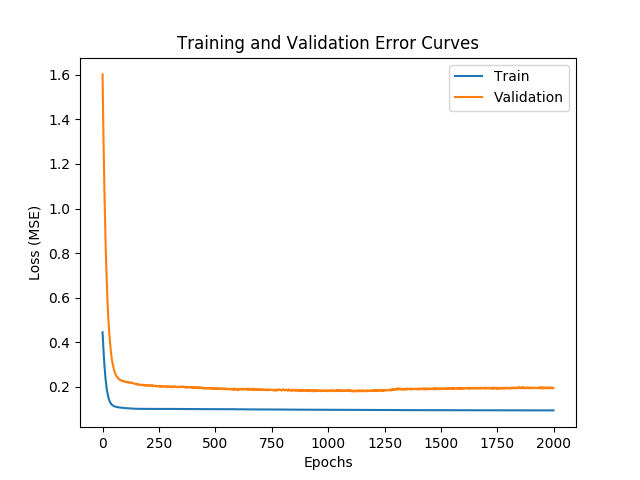

<IPython.core.display.Javascript object>


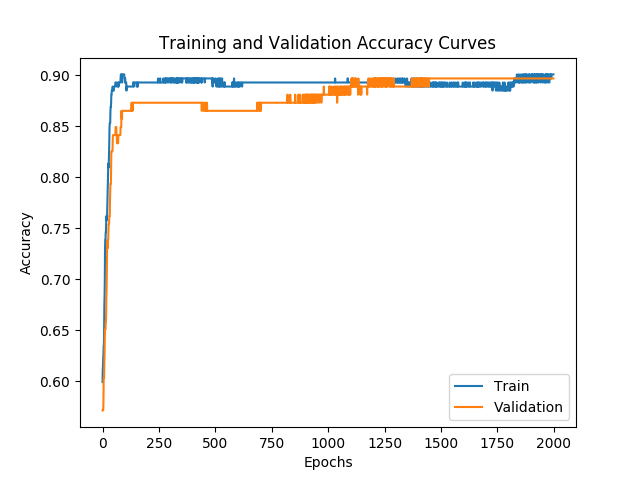

In [17]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 2 (5)

In [19]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 1.3601 - acc: 0.4405 - val_loss: 1.1922 - val_acc: 0.4683
Epoch 2/2000
252/252 [==============================] - 0s - loss: 1.2811 - acc: 0.4563 - val_loss: 1.1033 - val_acc: 0.4921
Epoch 3/2000
252/252 [==============================] - 0s - loss: 1.2019 - acc: 0.4802 - val_loss: 1.0204 - val_acc: 0.5159
Epoch 4/2000
252/252 [==============================] - 0s - loss: 1.1416 - acc: 0.5079 - val_loss: 0.9440 - val_acc: 0.5317
Epoch 5/2000
252/252 [==============================] - 0s - loss: 1.0718 - acc: 0.5317 - val_loss: 0.8763 - val_acc: 0.5635
Epoch 6/2000
252/252 [==============================] - 0s - loss: 1.0256 - acc: 0.5675 - val_loss: 0.8200 - val_acc: 0.5476
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.9739 - acc: 0.5913 - val_loss: 0.7732 - val_acc: 0.5317
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.9266 - acc

252/252 [==============================] - 0s - loss: 0.2155 - acc: 0.7976 - val_loss: 0.3771 - val_acc: 0.7778
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.2120 - acc: 0.7976 - val_loss: 0.3779 - val_acc: 0.7778
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.2103 - acc: 0.7976 - val_loss: 0.3780 - val_acc: 0.7857
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.2072 - acc: 0.7976 - val_loss: 0.3790 - val_acc: 0.7857
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.2037 - acc: 0.8016 - val_loss: 0.3770 - val_acc: 0.7857
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.2018 - acc: 0.8016 - val_loss: 0.3753 - val_acc: 0.7857
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1993 - acc: 0.8016 - val_loss: 0.3746 - val_acc: 0.7857
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1968 - acc: 0.8056 - val_loss: 0.3753 - val_acc: 0.7857
Epoch 

252/252 [==============================] - 0s - loss: 0.1292 - acc: 0.8452 - val_loss: 0.3726 - val_acc: 0.8492
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1288 - acc: 0.8452 - val_loss: 0.3704 - val_acc: 0.8492
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1284 - acc: 0.8452 - val_loss: 0.3685 - val_acc: 0.8492
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1280 - acc: 0.8452 - val_loss: 0.3676 - val_acc: 0.8492
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1277 - acc: 0.8452 - val_loss: 0.3670 - val_acc: 0.8492
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1273 - acc: 0.8452 - val_loss: 0.3674 - val_acc: 0.8492
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1270 - acc: 0.8452 - val_loss: 0.3658 - val_acc: 0.8492
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1266 - acc: 0.8452 - val_loss: 0.3653 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.1140 - acc: 0.8730 - val_loss: 0.3345 - val_acc: 0.8651
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.1139 - acc: 0.8730 - val_loss: 0.3351 - val_acc: 0.8651
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.1138 - acc: 0.8730 - val_loss: 0.3327 - val_acc: 0.8651
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.1136 - acc: 0.8730 - val_loss: 0.3316 - val_acc: 0.8651
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.1136 - acc: 0.8730 - val_loss: 0.3334 - val_acc: 0.8651
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.1134 - acc: 0.8730 - val_loss: 0.3321 - val_acc: 0.8651
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.1133 - acc: 0.8730 - val_loss: 0.3292 - val_acc: 0.8651
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.1131 - acc: 0.8730 - val_loss: 0.3298 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8889 - val_loss: 0.2827 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8889 - val_loss: 0.2854 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1067 - acc: 0.8889 - val_loss: 0.2828 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.2817 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.2817 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1063 - acc: 0.8889 - val_loss: 0.2805 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1062 - acc: 0.8889 - val_loss: 0.2788 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1061 - acc: 0.8889 - val_loss: 0.2770 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.9008 - val_loss: 0.2422 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.9008 - val_loss: 0.2412 - val_acc: 0.8730
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.1017 - acc: 0.9008 - val_loss: 0.2412 - val_acc: 0.8730
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.9008 - val_loss: 0.2401 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.9008 - val_loss: 0.2400 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.9008 - val_loss: 0.2404 - val_acc: 0.8730
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.9008 - val_loss: 0.2397 - val_acc: 0.8730
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.9008 - val_loss: 0.2405 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.9127 - val_loss: 0.2188 - val_acc: 0.8810
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.9127 - val_loss: 0.2181 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.9127 - val_loss: 0.2197 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.9127 - val_loss: 0.2203 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0990 - acc: 0.9127 - val_loss: 0.2198 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0990 - acc: 0.9127 - val_loss: 0.2190 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0990 - acc: 0.9127 - val_loss: 0.2198 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.9127 - val_loss: 0.2174 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.9167 - val_loss: 0.1938 - val_acc: 0.8889
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.9206 - val_loss: 0.1946 - val_acc: 0.8889
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.9206 - val_loss: 0.1938 - val_acc: 0.8889
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.9206 - val_loss: 0.1931 - val_acc: 0.8889
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.9206 - val_loss: 0.1940 - val_acc: 0.8889
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.9206 - val_loss: 0.1926 - val_acc: 0.8889
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.9206 - val_loss: 0.1931 - val_acc: 0.8889
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.9206 - val_loss: 0.1933 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9246 - val_loss: 0.1891 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.9246 - val_loss: 0.1872 - val_acc: 0.8730
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9246 - val_loss: 0.1884 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.9246 - val_loss: 0.1891 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.9246 - val_loss: 0.1886 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9206 - val_loss: 0.1878 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.9206 - val_loss: 0.1893 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.9206 - val_loss: 0.1879 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9167 - val_loss: 0.1846 - val_acc: 0.8571
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0920 - acc: 0.9167 - val_loss: 0.1814 - val_acc: 0.8651
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9167 - val_loss: 0.1822 - val_acc: 0.8571
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9206 - val_loss: 0.1841 - val_acc: 0.8571
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.9206 - val_loss: 0.1849 - val_acc: 0.8571
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.9206 - val_loss: 0.1826 - val_acc: 0.8571
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.9206 - val_loss: 0.1828 - val_acc: 0.8571
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.9206 - val_loss: 0.1828 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9167 - val_loss: 0.1756 - val_acc: 0.8571
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.9167 - val_loss: 0.1782 - val_acc: 0.8651
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9167 - val_loss: 0.1761 - val_acc: 0.8651
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9167 - val_loss: 0.1730 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9206 - val_loss: 0.1732 - val_acc: 0.8651
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9167 - val_loss: 0.1729 - val_acc: 0.8651
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9167 - val_loss: 0.1740 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.9167 - val_loss: 0.1759 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.9127 - val_loss: 0.1725 - val_acc: 0.8651
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.9127 - val_loss: 0.1732 - val_acc: 0.8651
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.9127 - val_loss: 0.1731 - val_acc: 0.8651
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.9127 - val_loss: 0.1732 - val_acc: 0.8651
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.9167 - val_loss: 0.1729 - val_acc: 0.8651
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.9167 - val_loss: 0.1721 - val_acc: 0.8651
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.9127 - val_loss: 0.1738 - val_acc: 0.8651
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.9127 - val_loss: 0.1727 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9127 - val_loss: 0.1705 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9087 - val_loss: 0.1665 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9087 - val_loss: 0.1673 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9127 - val_loss: 0.1673 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9087 - val_loss: 0.1681 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9087 - val_loss: 0.1697 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9087 - val_loss: 0.1704 - val_acc: 0.8730
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9087 - val_loss: 0.1695 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9167 - val_loss: 0.1612 - val_acc: 0.8730
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9127 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9167 - val_loss: 0.1615 - val_acc: 0.8730
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9167 - val_loss: 0.1617 - val_acc: 0.8730
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9127 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9127 - val_loss: 0.1609 - val_acc: 0.8651
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9127 - val_loss: 0.1629 - val_acc: 0.8730
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9167 - val_loss: 0.1597 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9167 - val_loss: 0.1571 - val_acc: 0.8651
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9167 - val_loss: 0.1570 - val_acc: 0.8651
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9167 - val_loss: 0.1563 - val_acc: 0.8651
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9206 - val_loss: 0.1549 - val_acc: 0.8651
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9206 - val_loss: 0.1524 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9206 - val_loss: 0.1558 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9206 - val_loss: 0.1553 - val_acc: 0.8651
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9206 - val_loss: 0.1570 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9246 - val_loss: 0.1489 - val_acc: 0.8651
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9246 - val_loss: 0.1497 - val_acc: 0.8651
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9246 - val_loss: 0.1488 - val_acc: 0.8651
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9246 - val_loss: 0.1501 - val_acc: 0.8651
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.9246 - val_loss: 0.1487 - val_acc: 0.8651
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.9246 - val_loss: 0.1504 - val_acc: 0.8651
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9246 - val_loss: 0.1477 - val_acc: 0.8651
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9246 - val_loss: 0.1492 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9325 - val_loss: 0.1582 - val_acc: 0.8651
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9325 - val_loss: 0.1563 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9286 - val_loss: 0.1562 - val_acc: 0.8651
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9286 - val_loss: 0.1566 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9286 - val_loss: 0.1570 - val_acc: 0.8651
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9286 - val_loss: 0.1555 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9286 - val_loss: 0.1542 - val_acc: 0.8651
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9286 - val_loss: 0.1530 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9325 - val_loss: 0.1453 - val_acc: 0.8651
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9325 - val_loss: 0.1459 - val_acc: 0.8651
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9325 - val_loss: 0.1464 - val_acc: 0.8651
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9325 - val_loss: 0.1462 - val_acc: 0.8651
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9325 - val_loss: 0.1427 - val_acc: 0.8651
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9325 - val_loss: 0.1416 - val_acc: 0.8651
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9325 - val_loss: 0.1420 - val_acc: 0.8651
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9325 - val_loss: 0.1447 - val_acc:

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9365 - val_loss: 0.1248 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9365 - val_loss: 0.1235 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9365 - val_loss: 0.1255 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9365 - val_loss: 0.1254 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9365 - val_loss: 0.1233 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9365 - val_loss: 0.1195 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9405 - val_loss: 0.1201 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9365 - val_loss: 0.1192 - val_acc:

252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9365 - val_loss: 0.1091 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9405 - val_loss: 0.1090 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9365 - val_loss: 0.1105 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9365 - val_loss: 0.1100 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9405 - val_loss: 0.1101 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9365 - val_loss: 0.1073 - val_acc: 0.8968
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9405 - val_loss: 0.1054 - val_acc: 0.8968
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9405 - val_loss: 0.1063 - val_acc:

252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.0982 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9325 - val_loss: 0.0990 - val_acc: 0.8968
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9325 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9325 - val_loss: 0.0990 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9325 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9325 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9325 - val_loss: 0.0968 - val_acc: 0.8889
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9325 - val_loss: 0.0959 - val_acc:

252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.0937 - val_acc: 0.9048
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0922 - val_acc: 0.9048
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0928 - val_acc: 0.9048
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0916 - val_acc: 0.9048
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0914 - val_acc: 0.9048
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0926 - val_acc: 0.9048
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0954 - val_acc: 0.9048
Epoch 1352/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0936 - val_acc:

252/252 [==============================] - 0s - loss: 0.0652 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9286 - val_loss: 0.0880 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9286 - val_loss: 0.0865 - val_acc: 0.9127
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0849 - val_acc: 0.9127
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0848 - val_acc: 0.9048
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0848 - val_acc: 0.9127
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0843 - val_acc: 0.9048
Epoch 1416/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9286 - val_loss: 0.0846 - val_acc:

252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.0807 - val_acc: 0.9127
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.0794 - val_acc: 0.9127
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0805 - val_acc: 0.9127
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0802 - val_acc: 0.9206
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0803 - val_acc: 0.9127
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0803 - val_acc: 0.9206
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0799 - val_acc: 0.9206
Epoch 1480/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0804 - val_acc:

252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.0772 - val_acc: 0.9206
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9325 - val_loss: 0.0767 - val_acc: 0.9206
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9365 - val_loss: 0.0768 - val_acc: 0.9206
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9365 - val_loss: 0.0767 - val_acc: 0.9206
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9365 - val_loss: 0.0772 - val_acc: 0.9127
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.0767 - val_acc: 0.9206
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.0765 - val_acc: 0.9127
Epoch 1544/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9365 - val_loss: 0.0766 - val_acc:

252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9365 - val_loss: 0.0740 - val_acc: 0.9286
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9365 - val_loss: 0.0743 - val_acc: 0.9286
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9365 - val_loss: 0.0740 - val_acc: 0.9286
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9365 - val_loss: 0.0738 - val_acc: 0.9286
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9365 - val_loss: 0.0734 - val_acc: 0.9286
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9365 - val_loss: 0.0731 - val_acc: 0.9286
Epoch 1607/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9365 - val_loss: 0.0742 - val_acc: 0.9286
Epoch 1608/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.0744 - val_acc:

252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9365 - val_loss: 0.0725 - val_acc: 0.9286
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9365 - val_loss: 0.0730 - val_acc: 0.9286
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9325 - val_loss: 0.0728 - val_acc: 0.9286
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9325 - val_loss: 0.0731 - val_acc: 0.9286
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9365 - val_loss: 0.0719 - val_acc: 0.9286
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9365 - val_loss: 0.0722 - val_acc: 0.9286
Epoch 1671/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9365 - val_loss: 0.0725 - val_acc: 0.9286
Epoch 1672/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9325 - val_loss: 0.0730 - val_acc:

252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0720 - val_acc: 0.9286
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9405 - val_loss: 0.0712 - val_acc: 0.9286
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9405 - val_loss: 0.0713 - val_acc: 0.9286
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9365 - val_loss: 0.0718 - val_acc: 0.9286
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0719 - val_acc: 0.9286
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0714 - val_acc: 0.9286
Epoch 1735/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0713 - val_acc: 0.9286
Epoch 1736/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9365 - val_loss: 0.0715 - val_acc:

252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9325 - val_loss: 0.0709 - val_acc: 0.9286
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9286 - val_loss: 0.0707 - val_acc: 0.9286
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9286 - val_loss: 0.0707 - val_acc: 0.9286
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9286 - val_loss: 0.0704 - val_acc: 0.9286
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9325 - val_loss: 0.0700 - val_acc: 0.9286
Epoch 1799/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0704 - val_acc:

252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9286 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9286 - val_loss: 0.0707 - val_acc: 0.9286
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9246 - val_loss: 0.0701 - val_acc: 0.9286
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9246 - val_loss: 0.0702 - val_acc: 0.9286
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9246 - val_loss: 0.0704 - val_acc: 0.9286
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9286 - val_loss: 0.0703 - val_acc: 0.9286
Epoch 1862/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9286 - val_loss: 0.0704 - val_acc: 0.9286
Epoch 1863/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9286 - val_loss: 0.0705 - val_acc:

252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9246 - val_loss: 0.0706 - val_acc: 0.9286
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9246 - val_loss: 0.0707 - val_acc: 0.9286
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9246 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9246 - val_loss: 0.0706 - val_acc: 0.9286
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0706 - val_acc: 0.9286
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9246 - val_loss: 0.0711 - val_acc: 0.9286
Epoch 1927/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0705 - val_acc:

252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9246 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9246 - val_loss: 0.0710 - val_acc: 0.9286
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9246 - val_loss: 0.0707 - val_acc: 0.9286
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9246 - val_loss: 0.0709 - val_acc: 0.9286
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0712 - val_acc: 0.9286
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0716 - val_acc: 0.9286
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9246 - val_loss: 0.0714 - val_acc: 0.9286
Epoch 1990/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9246 - val_loss: 0.0710 - val_acc:

In [20]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.097576327409280059, 0.88583078491335376]


<IPython.core.display.Javascript object>


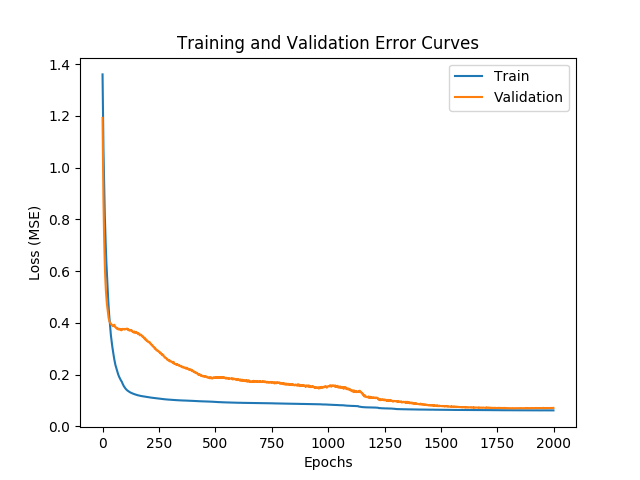

<IPython.core.display.Javascript object>


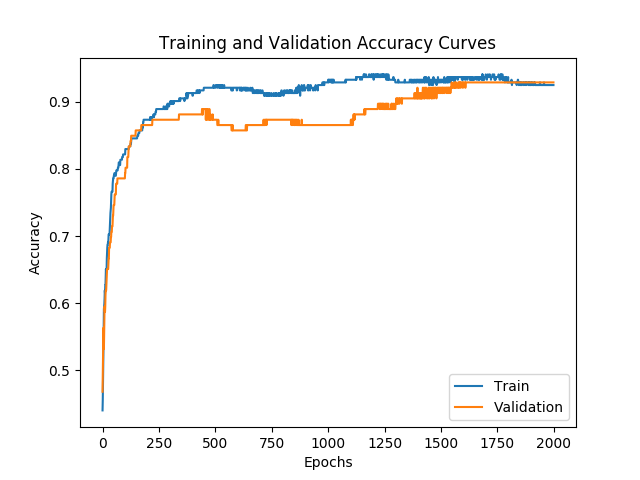

In [21]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 3 (3, 5)

In [22]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5611 - acc: 0.4048 - val_loss: 0.5253 - val_acc: 0.4762
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5479 - acc: 0.4206 - val_loss: 0.5156 - val_acc: 0.4683
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5366 - acc: 0.4206 - val_loss: 0.5067 - val_acc: 0.4683
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5258 - acc: 0.4325 - val_loss: 0.4982 - val_acc: 0.4683
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5163 - acc: 0.4524 - val_loss: 0.4900 - val_acc: 0.4603
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5064 - acc: 0.4563 - val_loss: 0.4800 - val_acc: 0.4762
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4909 - acc: 0.4603 - val_loss: 0.4643 - val_acc: 0.4921
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4690 - acc

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9048 - val_loss: 0.0995 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.0994 - val_acc: 0.8810
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.0995 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.0992 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9087 - val_loss: 0.0990 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9087 - val_loss: 0.0989 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.0989 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9087 - val_loss: 0.0987 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9087 - val_loss: 0.0932 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9127 - val_loss: 0.0936 - val_acc: 0.9048
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.0933 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9087 - val_loss: 0.0934 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9167 - val_loss: 0.0941 - val_acc: 0.8889
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9167 - val_loss: 0.0939 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9127 - val_loss: 0.0936 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9127 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9206 - val_loss: 0.0937 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 513/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0952 - val_acc: 0.8730
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9206 - val_loss: 0.0955 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0953 - val_acc: 0.8730
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0949 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9127 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0963 - val_acc: 0.8730
Epoch 641/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0966 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0960 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 769/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0977 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0980 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0978 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730
Epoch 897/2000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9206 - val_loss: 0.0994 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0998 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9206 - val_loss: 0.0995 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9206 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9206 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1006 - val_acc:

252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.1044 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9246 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9246 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1043 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.1044 - val_acc:

252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1056 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1063 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1060 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9206 - val_loss: 0.1060 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9206 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9246 - val_loss: 0.1069 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9206 - val_loss: 0.1068 - val_acc:

252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9246 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9206 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9206 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9206 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9246 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.1075 - val_acc:

252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9206 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9206 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9167 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9167 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1090 - val_acc:

252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8810
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1111 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9206 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9167 - val_loss: 0.1113 - val_acc: 0.8810
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1111 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9167 - val_loss: 0.1110 - val_acc:

252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9246 - val_loss: 0.1119 - val_acc: 0.8810
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9246 - val_loss: 0.1117 - val_acc: 0.8810
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9206 - val_loss: 0.1120 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1121 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1122 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.1124 - val_acc:

252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9286 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9286 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.1143 - val_acc:

In [23]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1856/1962 [===========================>..] - ETA: 0s[0.095942563334599551, 0.87359836901121302]


<IPython.core.display.Javascript object>


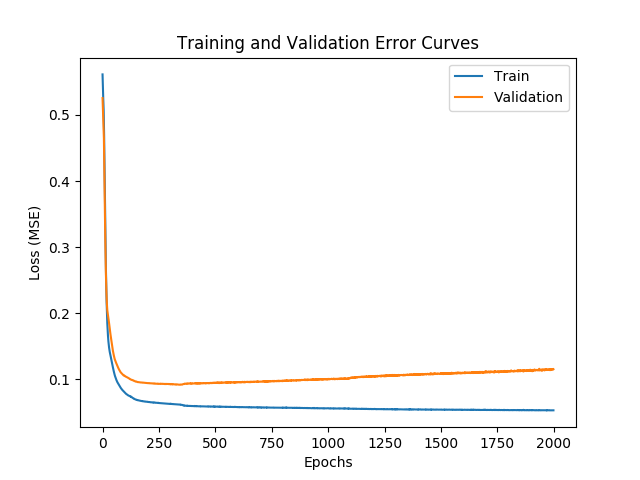

<IPython.core.display.Javascript object>


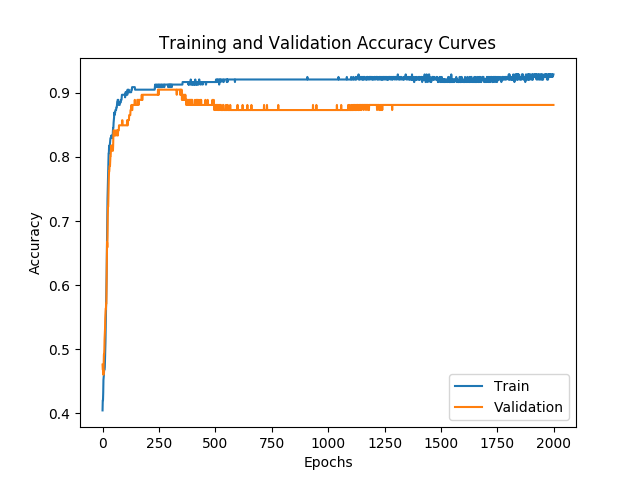

In [24]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 4 (5,3)

In [22]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5259 - acc: 0.4206 - val_loss: 0.4675 - val_acc: 0.4444
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4950 - acc: 0.4325 - val_loss: 0.4395 - val_acc: 0.4444
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4646 - acc: 0.4444 - val_loss: 0.4159 - val_acc: 0.4603
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4384 - acc: 0.4444 - val_loss: 0.3951 - val_acc: 0.4603
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4170 - acc: 0.4484 - val_loss: 0.3764 - val_acc: 0.4603
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3963 - acc: 0.4762 - val_loss: 0.3599 - val_acc: 0.4762
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3777 - acc: 0.5000 - val_loss: 0.3453 - val_acc: 0.4921
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3608 - acc

252/252 [==============================] - 0s - loss: 0.1161 - acc: 0.8571 - val_loss: 0.1682 - val_acc: 0.8571
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1150 - acc: 0.8571 - val_loss: 0.1671 - val_acc: 0.8571
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1141 - acc: 0.8571 - val_loss: 0.1663 - val_acc: 0.8571
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1132 - acc: 0.8571 - val_loss: 0.1658 - val_acc: 0.8571
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8611 - val_loss: 0.1655 - val_acc: 0.8571
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1118 - acc: 0.8611 - val_loss: 0.1650 - val_acc: 0.8571
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1109 - acc: 0.8611 - val_loss: 0.1645 - val_acc: 0.8492
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8611 - val_loss: 0.1642 - val_acc: 0.8492
Epoch 

252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8810 - val_loss: 0.1446 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8810 - val_loss: 0.1441 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8810 - val_loss: 0.1446 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8810 - val_loss: 0.1432 - val_acc: 0.8651
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8810 - val_loss: 0.1436 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8810 - val_loss: 0.1436 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8810 - val_loss: 0.1429 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8810 - val_loss: 0.1436 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8810 - val_loss: 0.1476 - val_acc: 0.8730
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8810 - val_loss: 0.1471 - val_acc: 0.8651
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8810 - val_loss: 0.1488 - val_acc: 0.8730
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1489 - val_acc: 0.8730
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1474 - val_acc: 0.8730
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1482 - val_acc: 0.8730
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1488 - val_acc: 0.8730
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1493 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8889 - val_loss: 0.1495 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8849 - val_loss: 0.1492 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8849 - val_loss: 0.1501 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8849 - val_loss: 0.1493 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8849 - val_loss: 0.1495 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8849 - val_loss: 0.1499 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8849 - val_loss: 0.1499 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8849 - val_loss: 0.1479 - val_acc: 0.8651
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.8849 - val_loss: 0.1461 - val_acc: 0.8651
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8849 - val_loss: 0.1457 - val_acc: 0.8730
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8849 - val_loss: 0.1472 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8849 - val_loss: 0.1468 - val_acc: 0.8651
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8849 - val_loss: 0.1470 - val_acc: 0.8651
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8849 - val_loss: 0.1450 - val_acc: 0.8730
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8849 - val_loss: 0.1451 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.8889 - val_loss: 0.1471 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8889 - val_loss: 0.1484 - val_acc: 0.8651
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8889 - val_loss: 0.1493 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8849 - val_loss: 0.1483 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8889 - val_loss: 0.1477 - val_acc: 0.8651
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.8889 - val_loss: 0.1478 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8651
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8889 - val_loss: 0.1485 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.8889 - val_loss: 0.1555 - val_acc: 0.8651
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8889 - val_loss: 0.1525 - val_acc: 0.8651
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.8929 - val_loss: 0.1521 - val_acc: 0.8651
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.8889 - val_loss: 0.1527 - val_acc: 0.8651
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8889 - val_loss: 0.1546 - val_acc: 0.8651
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8889 - val_loss: 0.1545 - val_acc: 0.8651
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.8889 - val_loss: 0.1544 - val_acc: 0.8651
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8889 - val_loss: 0.1540 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8889 - val_loss: 0.1534 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.8889 - val_loss: 0.1497 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.8889 - val_loss: 0.1492 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.8889 - val_loss: 0.1490 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8889 - val_loss: 0.1508 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8889 - val_loss: 0.1511 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8889 - val_loss: 0.1505 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.8889 - val_loss: 0.1502 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8968 - val_loss: 0.1494 - val_acc: 0.8730
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8730
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1505 - val_acc: 0.8730
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8889 - val_loss: 0.1483 - val_acc: 0.8730
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.8889 - val_loss: 0.1489 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8889 - val_loss: 0.1484 - val_acc: 0.8730
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.8968 - val_loss: 0.1484 - val_acc: 0.8730
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8968 - val_loss: 0.1501 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.8929 - val_loss: 0.1484 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9008 - val_loss: 0.1516 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8889 - val_loss: 0.1486 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.8968 - val_loss: 0.1484 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1508 - val_acc: 0.8730
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8968 - val_loss: 0.1494 - val_acc: 0.8730
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8968 - val_loss: 0.1486 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8968 - val_loss: 0.1478 - val_acc: 0.8651
Epoch 706/2000
252/252 [==============================] - ETA: 0s - loss: 0.1056 - acc: 0.875 - 0s - loss: 0.0835 - acc: 0.8968 - val_loss: 0.1493 - val_acc: 0.8651
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8968 - val_loss: 0.1477 - val_acc: 0.8651
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8968 - val_loss: 0.1475 - val_acc: 0.8651
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8968 - val_loss: 0.1480 - val_acc: 0.8651
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8968 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8968 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.896

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.8968 - val_loss: 0.1481 - val_acc: 0.8651
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.8968 - val_loss: 0.1483 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.8968 - val_loss: 0.1467 - val_acc: 0.8651
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.8968 - val_loss: 0.1478 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.8968 - val_loss: 0.1457 - val_acc: 0.8651
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.8968 - val_loss: 0.1470 - val_acc: 0.8651
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.8968 - val_loss: 0.1456 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.8968 - val_loss: 0.1472 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.8968 - val_loss: 0.1420 - val_acc: 0.8651
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.8968 - val_loss: 0.1444 - val_acc: 0.8651
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.8968 - val_loss: 0.1474 - val_acc: 0.8651
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.8968 - val_loss: 0.1453 - val_acc: 0.8651
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.8968 - val_loss: 0.1415 - val_acc: 0.8651
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.8968 - val_loss: 0.1427 - val_acc: 0.8651
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.8968 - val_loss: 0.1449 - val_acc: 0.8651
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.8968 - val_loss: 0.1459 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1419 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9048 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8968 - val_loss: 0.1400 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8968 - val_loss: 0.1412 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8968 - val_loss: 0.1404 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.8968 - val_loss: 0.1398 - val_acc: 0.8810
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1391 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1381 - val_acc: 0.8889
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1413 - val_acc: 0.8810
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1372 - val_acc: 0.8889
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1387 - val_acc: 0.8889
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1398 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1384 - val_acc: 0.8889
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.1371 - val_acc: 0.8889
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.1396 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1375 - val_acc: 0.8889
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9087 - val_loss: 0.1363 - val_acc: 0.8889
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9048 - val_loss: 0.1354 - val_acc: 0.8889
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1386 - val_acc: 0.8889
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1391 - val_acc: 0.8889
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9087 - val_loss: 0.1316 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9048 - val_loss: 0.1334 - val_acc: 0.8889
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.1385 - val_acc:

252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.1328 - val_acc: 0.8889
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.1346 - val_acc: 0.8889
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.1326 - val_acc: 0.8889
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9087 - val_loss: 0.1271 - val_acc: 0.8889
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.1296 - val_acc: 0.8889
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.1337 - val_acc: 0.8889
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.1360 - val_acc:

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.1303 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9087 - val_loss: 0.1279 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.1281 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9087 - val_loss: 0.1292 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.1292 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.1301 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9087 - val_loss: 0.1289 - val_acc: 0.8889
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.1283 - val_acc:

252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1239 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1261 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1268 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1289 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9087 - val_loss: 0.1244 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1229 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9087 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9087 - val_loss: 0.1235 - val_acc:

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1227 - val_acc: 0.8889
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9127 - val_loss: 0.1192 - val_acc: 0.8889
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1172 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1182 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1185 - val_acc:

252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9127 - val_loss: 0.1121 - val_acc: 0.8889
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1161 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8889
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9127 - val_loss: 0.1127 - val_acc: 0.8889
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9127 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9127 - val_loss: 0.1163 - val_acc: 0.8889
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9167 - val_loss: 0.1153 - val_acc:

252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9167 - val_loss: 0.1168 - val_acc: 0.8810
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9167 - val_loss: 0.1154 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9167 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9167 - val_loss: 0.1144 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9167 - val_loss: 0.1145 - val_acc: 0.8889
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9167 - val_loss: 0.1163 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9167 - val_loss: 0.1131 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9167 - val_loss: 0.1136 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9167 - val_loss: 0.1138 - val_acc: 0.8810
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9167 - val_loss: 0.1106 - val_acc: 0.8810
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1168 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9167 - val_loss: 0.1138 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9167 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9206 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9167 - val_loss: 0.1157 - val_acc: 0.8810
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9167 - val_loss: 0.1160 - val_acc:

252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9246 - val_loss: 0.1119 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9167 - val_loss: 0.1156 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9167 - val_loss: 0.1163 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9167 - val_loss: 0.1150 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9167 - val_loss: 0.1144 - val_acc: 0.8730
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9167 - val_loss: 0.1167 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9206 - val_loss: 0.1158 - val_acc: 0.8730
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9167 - val_loss: 0.1087 - val_acc:

252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9206 - val_loss: 0.1148 - val_acc: 0.8730
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9206 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9246 - val_loss: 0.1144 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9167 - val_loss: 0.1174 - val_acc: 0.8730
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9167 - val_loss: 0.1130 - val_acc: 0.8730
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9206 - val_loss: 0.1117 - val_acc: 0.8730
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9246 - val_loss: 0.1132 - val_acc: 0.8730
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9206 - val_loss: 0.1159 - val_acc:

252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9246 - val_loss: 0.1127 - val_acc: 0.8730
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9246 - val_loss: 0.1151 - val_acc: 0.8730
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9167 - val_loss: 0.1168 - val_acc: 0.8730
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9206 - val_loss: 0.1186 - val_acc: 0.8730
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9246 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9246 - val_loss: 0.1130 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9206 - val_loss: 0.1121 - val_acc: 0.8730
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9206 - val_loss: 0.1146 - val_acc:

252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9286 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9286 - val_loss: 0.1123 - val_acc: 0.8730
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9286 - val_loss: 0.1145 - val_acc: 0.8730
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9206 - val_loss: 0.1162 - val_acc: 0.8730
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9206 - val_loss: 0.1137 - val_acc: 0.8730
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9286 - val_loss: 0.1141 - val_acc: 0.8730
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9246 - val_loss: 0.1164 - val_acc: 0.8730
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9286 - val_loss: 0.1136 - val_acc:

252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9286 - val_loss: 0.1111 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9286 - val_loss: 0.1117 - val_acc: 0.8730
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9286 - val_loss: 0.1086 - val_acc: 0.8730
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9286 - val_loss: 0.1129 - val_acc: 0.8730
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9246 - val_loss: 0.1058 - val_acc: 0.8730
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9286 - val_loss: 0.1091 - val_acc: 0.8730
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9286 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9286 - val_loss: 0.1097 - val_acc:

252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9286 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9246 - val_loss: 0.1077 - val_acc: 0.8730
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9286 - val_loss: 0.1117 - val_acc: 0.8730
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1104 - val_acc: 0.8730
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9246 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9286 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1130 - val_acc: 0.8730
Epoch 1862/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.1159 - val_acc:

252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9246 - val_loss: 0.1126 - val_acc: 0.8730
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1124 - val_acc: 0.8730
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1088 - val_acc: 0.8730
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1085 - val_acc: 0.8730
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1121 - val_acc: 0.8730
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1082 - val_acc: 0.8730
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1122 - val_acc: 0.8730
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1098 - val_acc:

252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9286 - val_loss: 0.1099 - val_acc: 0.8730
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9286 - val_loss: 0.1152 - val_acc: 0.8730
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1118 - val_acc: 0.8730
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1137 - val_acc: 0.8730
Epoch 1990/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9286 - val_loss: 0.1054 - val_acc:

In [23]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1312/1962 [===================>..........] - ETA: 0s[0.08312309659812428, 0.91080530071355759]


<IPython.core.display.Javascript object>


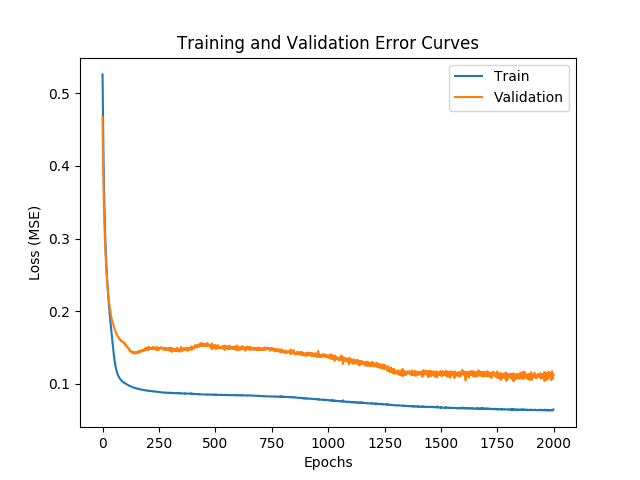

<IPython.core.display.Javascript object>


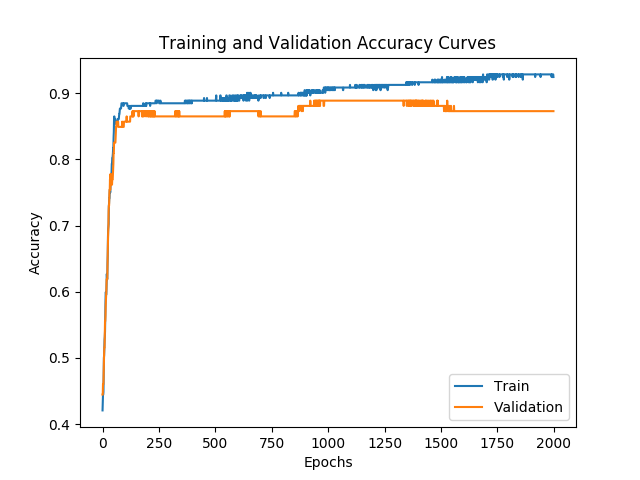

In [24]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 5 (2)

In [25]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.9313 - acc: 0.3373 - val_loss: 0.8230 - val_acc: 0.3968
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.8838 - acc: 0.3452 - val_loss: 0.7906 - val_acc: 0.3968
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.8410 - acc: 0.3492 - val_loss: 0.7593 - val_acc: 0.4048
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.8028 - acc: 0.3492 - val_loss: 0.7296 - val_acc: 0.4206
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.7665 - acc: 0.3571 - val_loss: 0.7021 - val_acc: 0.4206
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.7334 - acc: 0.3571 - val_loss: 0.6773 - val_acc: 0.4127
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.7011 - acc: 0.3651 - val_loss: 0.6551 - val_acc: 0.4286
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.6720 - acc

252/252 [==============================] - 0s - loss: 0.3736 - acc: 0.5635 - val_loss: 0.3959 - val_acc: 0.5952
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.3713 - acc: 0.5635 - val_loss: 0.3934 - val_acc: 0.5952
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.3685 - acc: 0.5635 - val_loss: 0.3909 - val_acc: 0.5952
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.3647 - acc: 0.5635 - val_loss: 0.3883 - val_acc: 0.5952
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.3613 - acc: 0.5675 - val_loss: 0.3857 - val_acc: 0.5952
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.3569 - acc: 0.5714 - val_loss: 0.3832 - val_acc: 0.5952
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.3523 - acc: 0.5754 - val_loss: 0.3806 - val_acc: 0.5952
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.3481 - acc: 0.5754 - val_loss: 0.3779 - val_acc: 0.5873
Epoch 

252/252 [==============================] - 0s - loss: 0.1661 - acc: 0.7778 - val_loss: 0.1877 - val_acc: 0.7619
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1641 - acc: 0.7857 - val_loss: 0.1844 - val_acc: 0.7619
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1624 - acc: 0.7937 - val_loss: 0.1820 - val_acc: 0.7619
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1609 - acc: 0.8056 - val_loss: 0.1799 - val_acc: 0.7778
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1592 - acc: 0.8135 - val_loss: 0.1782 - val_acc: 0.7857
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1578 - acc: 0.8135 - val_loss: 0.1763 - val_acc: 0.7857
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1562 - acc: 0.8175 - val_loss: 0.1745 - val_acc: 0.7778
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1547 - acc: 0.8175 - val_loss: 0.1730 - val_acc: 0.7778

252/252 [==============================] - 0s - loss: 0.1191 - acc: 0.8690 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.1189 - acc: 0.8690 - val_loss: 0.1633 - val_acc: 0.8492
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.1187 - acc: 0.8690 - val_loss: 0.1632 - val_acc: 0.8492
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.1184 - acc: 0.8690 - val_loss: 0.1637 - val_acc: 0.8492
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.1183 - acc: 0.8770 - val_loss: 0.1636 - val_acc: 0.8492
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.1180 - acc: 0.8770 - val_loss: 0.1634 - val_acc: 0.8492
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.1178 - acc: 0.8770 - val_loss: 0.1631 - val_acc: 0.8492
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.1176 - acc: 0.8770 - val_loss: 0.1630 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8810 - val_loss: 0.1572 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1099 - acc: 0.8810 - val_loss: 0.1571 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1098 - acc: 0.8810 - val_loss: 0.1572 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1098 - acc: 0.8810 - val_loss: 0.1571 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8810 - val_loss: 0.1570 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8810 - val_loss: 0.1570 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8810 - val_loss: 0.1571 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.1070 - acc: 0.8889 - val_loss: 0.1574 - val_acc: 0.8810
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.1070 - acc: 0.8889 - val_loss: 0.1574 - val_acc: 0.8810
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.1070 - acc: 0.8849 - val_loss: 0.1573 - val_acc: 0.8810
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8849 - val_loss: 0.1575 - val_acc: 0.8810
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8889 - val_loss: 0.1577 - val_acc: 0.8810
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8889 - val_loss: 0.1577 - val_acc: 0.8810
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8889 - val_loss: 0.1575 - val_acc: 0.8810
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8889 - val_loss: 0.1576 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1572 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1574 - val_acc: 0.8889
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1575 - val_acc: 0.8889
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1575 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1574 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8929 - val_loss: 0.1576 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1570 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1570 - val_acc: 0.8730
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1572 - val_acc: 0.8730
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1566 - val_acc: 0.8810
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1567 - val_acc: 0.8810
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1570 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1575 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1571 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1565 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - ETA: 0s - loss: 0.1502 - acc: 0.875 - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1562 - val_acc: 0.8889
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1563 - val_acc: 0.8889
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1565 - val_acc: 0.8810
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.892

252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8929 - val_loss: 0.1565 - val_acc: 0.8889
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1568 - val_acc: 0.8730
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1566 - val_acc: 0.8730
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1569 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1564 - val_acc: 0.8810
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1563 - val_acc: 0.8889
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1564 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1566 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1567 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1556 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1554 - val_acc: 0.8810
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1556 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1554 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1561 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1556 - val_acc: 0.8810
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1559 - val_acc: 0.8810
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1560 - val_acc: 0.8810
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1554 - val_acc: 0.8810
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1553 - val_acc: 0.8810
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1558 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1553 - val_acc: 0.8810
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1551 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1553 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1552 - val_acc: 0.8810
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1552 - val_acc: 0.8810
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1552 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.9008 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1551 - val_acc: 0.8810
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1552 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1550 - val_acc:

252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1549 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1538 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1223/2000
252/252 [==============================] - ETA: 0s - loss: 0.1729 - acc: 0.812 - 0s - loss: 0.1057 - acc

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1533 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1343/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1551 - val_acc: 0.8810
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1537 - val_acc:

252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1470/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.9008 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8968 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1542 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8929 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - ETA: 0s - loss: 0.1453 - acc: 0.875 - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1551 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1546 - val_acc: 0.8810
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1536 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - ETA: 0s - loss: 0.1078 - acc: 0.937 - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1852/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1536 - val_acc: 0.8810
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1542 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 1916/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1539 - val_acc:

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8968 - val_loss: 0.1543 - val_acc: 0.8810
Epoch 1983/2000
252/252 [==============================] - ETA: 0s - loss: 0.0894 - acc: 0.937 - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.9008 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.9008 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc

In [26]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.075694690079681728, 0.89500509671844108]


<IPython.core.display.Javascript object>


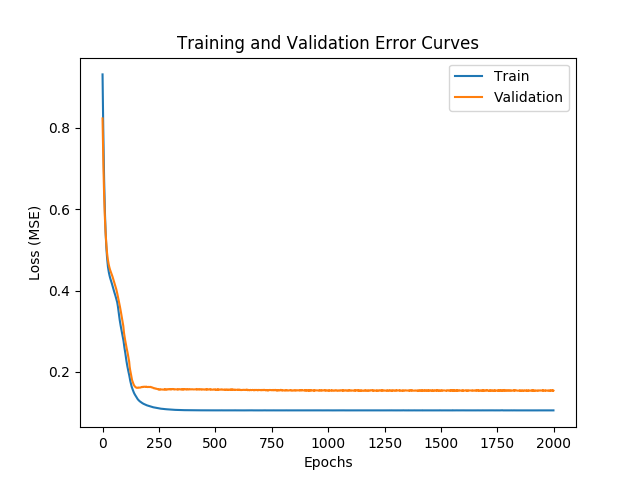

<IPython.core.display.Javascript object>


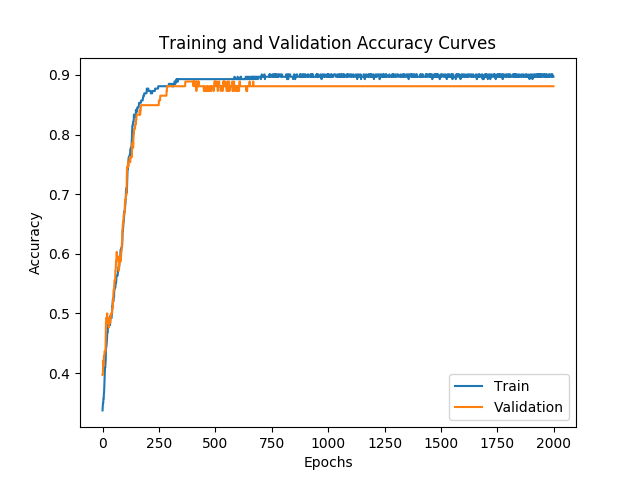

In [27]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 6 (4)

In [28]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5283 - acc: 0.4405 - val_loss: 0.9177 - val_acc: 0.5000
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5149 - acc: 0.4444 - val_loss: 0.8728 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5036 - acc: 0.4524 - val_loss: 0.8331 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4940 - acc: 0.4683 - val_loss: 0.7973 - val_acc: 0.5079
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4859 - acc: 0.4722 - val_loss: 0.7668 - val_acc: 0.5159
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4799 - acc: 0.4802 - val_loss: 0.7343 - val_acc: 0.5159
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4712 - acc: 0.4762 - val_loss: 0.7089 - val_acc: 0.5159
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4642 - acc

252/252 [==============================] - 0s - loss: 0.1225 - acc: 0.8651 - val_loss: 0.1500 - val_acc: 0.8175
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1218 - acc: 0.8651 - val_loss: 0.1483 - val_acc: 0.8254
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1213 - acc: 0.8611 - val_loss: 0.1478 - val_acc: 0.8254
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1204 - acc: 0.8571 - val_loss: 0.1467 - val_acc: 0.8333
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1200 - acc: 0.8571 - val_loss: 0.1454 - val_acc: 0.8333
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1194 - acc: 0.8611 - val_loss: 0.1447 - val_acc: 0.8254
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1189 - acc: 0.8651 - val_loss: 0.1441 - val_acc: 0.8254
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1186 - acc: 0.8651 - val_loss: 0.1433 - val_acc: 0.8333
Epoch 

252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8849 - val_loss: 0.1263 - val_acc: 0.8492
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1072 - acc: 0.8849 - val_loss: 0.1258 - val_acc: 0.8492
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8849 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1070 - acc: 0.8849 - val_loss: 0.1252 - val_acc: 0.8413
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8889 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8889 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8849 - val_loss: 0.1240 - val_acc: 0.8571
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1067 - acc: 0.8889 - val_loss: 0.1241 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8968 - val_loss: 0.1337 - val_acc: 0.8651
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8968 - val_loss: 0.1337 - val_acc: 0.8651
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8968 - val_loss: 0.1332 - val_acc: 0.8651
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1338 - val_acc: 0.8651
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1335 - val_acc: 0.8651
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1327 - val_acc: 0.8651
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.9008 - val_loss: 0.1323 - val_acc: 0.8651
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.9008 - val_loss: 0.1323 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1228 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1228 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1224 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1222 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1222 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9087 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1131 - val_acc: 0.8730
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1127 - val_acc: 0.8730
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1128 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1131 - val_acc: 0.8730
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1128 - val_acc: 0.8730
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1128 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8929 - val_loss: 0.1065 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.8968 - val_loss: 0.1060 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8929 - val_loss: 0.1066 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.8889 - val_loss: 0.1061 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8929 - val_loss: 0.1059 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8968 - val_loss: 0.1058 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.8929 - val_loss: 0.1061 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.8929 - val_loss: 0.1061 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.8889 - val_loss: 0.0999 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.8889 - val_loss: 0.0998 - val_acc: 0.8810
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.8889 - val_loss: 0.0998 - val_acc: 0.8810
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.8889 - val_loss: 0.0996 - val_acc: 0.8810
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.8889 - val_loss: 0.0993 - val_acc: 0.8889
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.8889 - val_loss: 0.0997 - val_acc: 0.8810
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.8889 - val_loss: 0.0994 - val_acc: 0.8810
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.8889 - val_loss: 0.0995 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.8968 - val_loss: 0.0943 - val_acc: 0.8968
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.8929 - val_loss: 0.0943 - val_acc: 0.8968
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.8929 - val_loss: 0.0941 - val_acc: 0.8968
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.8929 - val_loss: 0.0944 - val_acc: 0.8968
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.8929 - val_loss: 0.0943 - val_acc: 0.8968
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.8929 - val_loss: 0.0941 - val_acc: 0.8968
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.8929 - val_loss: 0.0939 - val_acc: 0.8968
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.8929 - val_loss: 0.0941 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.8929 - val_loss: 0.0913 - val_acc: 0.9048
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.8929 - val_loss: 0.0911 - val_acc: 0.9048
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.8929 - val_loss: 0.0910 - val_acc: 0.9048
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.8929 - val_loss: 0.0910 - val_acc: 0.8968
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.8929 - val_loss: 0.0910 - val_acc: 0.8968
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.8929 - val_loss: 0.0910 - val_acc: 0.8968
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.8929 - val_loss: 0.0911 - val_acc: 0.9048
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.8929 - val_loss: 0.0910 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0898 - val_acc: 0.8968
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0899 - val_acc: 0.8968
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8929 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.8929 - val_loss: 0.0898 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.8929 - val_loss: 0.0898 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.8968 - val_loss: 0.0882 - val_acc: 0.8968
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.8968 - val_loss: 0.0882 - val_acc: 0.8968
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.8968 - val_loss: 0.0881 - val_acc: 0.8968
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.8968 - val_loss: 0.0881 - val_acc: 0.8968
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.8968 - val_loss: 0.0881 - val_acc: 0.8968
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.8968 - val_loss: 0.0882 - val_acc: 0.8968
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.8968 - val_loss: 0.0882 - val_acc: 0.8968
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.8968 - val_loss: 0.0880 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.0861 - val_acc: 0.8968
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.8968 - val_loss: 0.0861 - val_acc: 0.8968
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.0861 - val_acc: 0.8968
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.8968 - val_loss: 0.0861 - val_acc: 0.8968
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.8968 - val_loss: 0.0861 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9008 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9048 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9048 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9048 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9048 - val_loss: 0.0863 - val_acc: 0.8968
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9048 - val_loss: 0.0864 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9048 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9048 - val_loss: 0.0872 - val_acc: 0.8968
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.0872 - val_acc: 0.8968
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9087 - val_loss: 0.0872 - val_acc: 0.8968
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9048 - val_loss: 0.0874 - val_acc: 0.8968
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9087 - val_loss: 0.0872 - val_acc: 0.8968
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9087 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9087 - val_loss: 0.0871 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9087 - val_loss: 0.0877 - val_acc: 0.8968
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.0878 - val_acc: 0.8968
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.0878 - val_acc: 0.8968
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.0877 - val_acc: 0.8968
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.0878 - val_acc: 0.8968
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9087 - val_loss: 0.0878 - val_acc: 0.8968
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.0877 - val_acc:

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.0881 - val_acc: 0.8968
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9087 - val_loss: 0.0880 - val_acc: 0.8968
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9087 - val_loss: 0.0880 - val_acc: 0.8968
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.0877 - val_acc: 0.8968
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9087 - val_loss: 0.0881 - val_acc:

252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0881 - val_acc: 0.8968
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0882 - val_acc: 0.8968
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0884 - val_acc: 0.8968
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.0881 - val_acc:

252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9087 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.0882 - val_acc: 0.8968
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0884 - val_acc: 0.8968
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0885 - val_acc: 0.8968
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0885 - val_acc: 0.8968
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0884 - val_acc: 0.8968
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0884 - val_acc:

252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9087 - val_loss: 0.0886 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9087 - val_loss: 0.0886 - val_acc: 0.8968
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9048 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.0888 - val_acc: 0.8968
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.0888 - val_acc: 0.8968
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9087 - val_loss: 0.0889 - val_acc:

252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9087 - val_loss: 0.0890 - val_acc: 0.8968
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9048 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9048 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.0892 - val_acc: 0.8968
Epoch 1349/2000
252/252 [==============================] - ETA: 0s - loss: 0.1424 - acc: 0.781 - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9048 - val_loss: 0.0889 - val_acc: 0.8968
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9048 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1352/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.0895 - val_acc: 0.8968
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9048 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9048 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9048 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9048 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9048 - val_loss: 0.0895 - val_acc: 0.8968
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.0896 - val_acc:

252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9048 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.0899 - val_acc: 0.8968
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.0898 - val_acc: 0.8968
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9048 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9048 - val_loss: 0.0898 - val_acc: 0.8968
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9048 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.0898 - val_acc:

252/252 [==============================] - ETA: 0s - loss: 0.0188 - acc: 0.968 - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9048 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9048 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9048 - val_loss: 0.0899 - val_acc: 0.8968
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.0898 - val_acc: 0.8968
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0900 - val_acc: 0.8968
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.0904 - val_acc: 0.8968
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0906 - val_acc: 0.8968
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0904 - val_acc: 0.8968
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0903 - val_acc: 0.8968
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0903 - val_acc: 0.8968
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0904 - val_acc: 0.8968
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.0908 - val_acc:

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0908 - val_acc: 0.8968
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0910 - val_acc: 0.8968
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.0906 - val_acc: 0.8968
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0911 - val_acc: 0.8968
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0910 - val_acc: 0.8968
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0908 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0912 - val_acc: 0.8968
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.0915 - val_acc: 0.8968
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.0912 - val_acc: 0.8968
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.0914 - val_acc: 0.8968
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.0916 - val_acc: 0.8968
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0914 - val_acc: 0.8968
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0914 - val_acc:

252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0921 - val_acc: 0.8968
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0919 - val_acc: 0.8968
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0916 - val_acc: 0.8968
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.0916 - val_acc: 0.8968
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0919 - val_acc: 0.8968
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0921 - val_acc:

252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0922 - val_acc: 0.8968
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0926 - val_acc: 0.8889
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0926 - val_acc: 0.8889
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8968
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.0924 - val_acc: 0.8968
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0925 - val_acc: 0.8889
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.0925 - val_acc:

252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.0929 - val_acc: 0.8889
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.0930 - val_acc:

252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.0930 - val_acc: 0.8889
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 1986/2000
252/252 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.937 - 0s - loss: 0.0689 - acc

In [29]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

 896/1962 [============>.................] - ETA: 0s[0.075822799402943203, 0.87665647286523007]


<IPython.core.display.Javascript object>


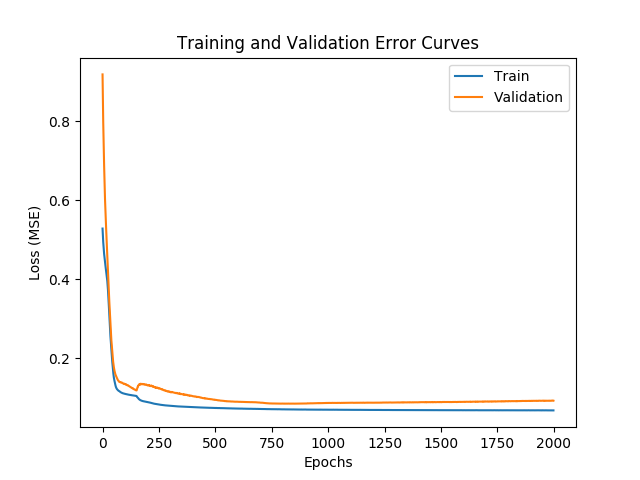

<IPython.core.display.Javascript object>


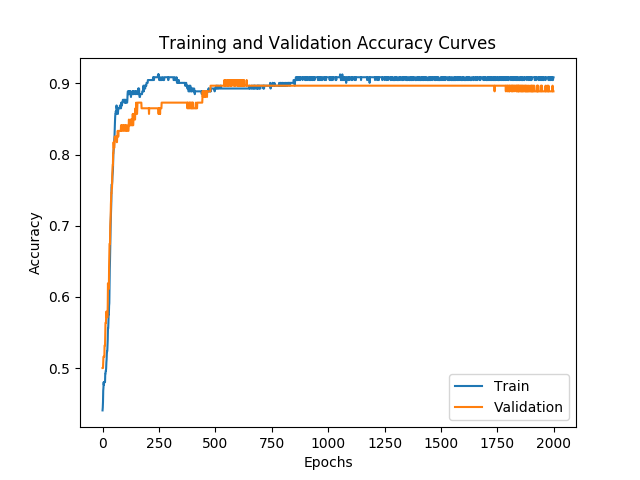

In [30]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
